# Информация о покупателях с добавлением меток классов (olist_classified_public_dataset.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sys, os
import pathlib
from pathlib import Path
from pydantic import ValidationError
from olist_churn_prediction.paths import SRC_DIR, PROCESSED_DIR, INTERIM_DIR

In [2]:
from olist_churn_prediction import feature_processing, feature_engineering
from olist_churn_prediction.feature_engineering import DateDiffTransformer
from olist_churn_prediction.schemas_raw import MainClassifiedSchemaRaw
from olist_churn_prediction.paths import RAW_DIR
from sklearn.pipeline import Pipeline, FeatureUnion

In [49]:
classified_data = pd.read_csv(RAW_DIR / "olist_classified_public_dataset.csv", low_memory=False)

In [50]:
display(classified_data.head())
classified_data.shape

,Unnamed: 0,id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,...,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class
0,0,1,delivered,89.99,14.38,1,1,2017-08-30 11:41:01.000000,2017-08-30 11:55:08.970352,2017-09-21 00:00:00.000000,...,0,0,0,0,0,0,0,3,satisfeito,satisfeito_com_pedido
1,1,2,delivered,69.00,15.23,1,1,2017-09-26 09:13:36.000000,2017-09-26 09:28:10.922048,2017-10-24 00:00:00.000000,...,0,0,0,0,0,0,0,0,antes_prazo,satisfeito_com_pedido
2,2,3,delivered,99.80,15.86,2,4,2018-01-15 15:50:42.000000,2018-01-17 07:29:56.419769,2018-02-05 00:00:00.000000,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
3,3,4,delivered,87.00,12.74,1,1,2018-02-04 11:16:42.000000,2018-02-06 05:31:50.990164,2018-03-13 00:00:00.000000,...,3,0,0,0,0,0,0,0,atrasado,problemas_de_entrega
4,4,5,delivered,99.90,17.95,1,2,2017-12-07 11:58:42.000000,2017-12-08 02:36:49.587515,2018-01-03 00:00:00.000000,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega


(3584, 34)

In [51]:
print(classified_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     3584 non-null   int64  
 1   id                             3584 non-null   int64  
 2   order_status                   3584 non-null   object 
 3   order_products_value           3584 non-null   float64
 4   order_freight_value            3584 non-null   float64
 5   order_items_qty                3584 non-null   int64  
 6   order_sellers_qty              3584 non-null   int64  
 7   order_purchase_timestamp       3584 non-null   object 
 8   order_aproved_at               3584 non-null   object 
 9   order_estimated_delivery_date  3584 non-null   object 
 10  order_delivered_customer_date  3467 non-null   object 
 11  customer_city                  3584 non-null   object 
 12  customer_state                 3584 non-null   o

### Пояснения к признакам:
1. *id* - id;
2. *order_status* - статус заказа;
3. *order_products_value* - суммарная стоимость товаров в заказе;
4. *order_freight_value* - стоимость доставки;
5. *order_items_qty* - количество товаров в заказе;
6. *order_sellers_qty* - неясно, пояснений от заказчика нет, лучше удалить;
7. *order_purchase_timestamp* - время покупки;
8. *order_aproved_at* - время подтверждения заказа;
9. *order_estimated_delivery_date* - ожидаемая дата доставки;
10. *order_delivered_customer_date* - время доставки;
11. *customer_city* - город покупателя;
12. *customer_state* - штат (регион) покупателя;
13. *customer_zip_code_prefix* - число принадлежности к определенному региону для покупателя (аналог почтового индекса);
14. *product_category_name* - название категории товара;
15. *product_name_lenght* - длина названия товара в символах;
16. *product_description_lenght* - длина описания товара в символах;
17. *product_photos_qty* - количество фото товара;
18. *review_score* - оценка товара по пятибальной шкале;
19. *review_comment_title* - все значения NaN, удалить;
20. *review_comment_message* - обзор на товар;
21. *review_creation_date* - дата создания анкеты для пользователя с целью оценить качество услуг;
22. *review_answer_timestamp* - дата ответа пользователем на анкету;
23. *votes_before_estimate* - голоса экспертов за то, что товар приехал ранее ориентировочного срока;
24. *votes_delayed* - голоса экспертов за опоздание товара;
25. *votes_low_quality* - голоса экспертов за низкое качество товара;
26. *votes_return* - голоса экспертов за то, был ли возвращен товар на основе содержания комментария к этому товару;
27. *votes_not_as_anounced* - голоса экспертов за несоответствие товара ожиданию;
28. *votes_partial_delivery* - голоса экспертов за факт доставки неполной комплектации товара;
29. *votes_other_delivery* - не до конца ясно, предположительно, доставка неправильного вида;
30. *votes_other_order* - голоса за получение неправильного заказа;
31. *votes_satisfied* - голоса за то, удовлетворен ли покупатель;
32. *most_voted_subclass* - второй по количеству голосов класс комментария пользователя;
33. *most_voted_class* - первый по количеству голосов класс.

Удалим *unnamed: 0*, *id* и *review_comment_title*. *Unnamed: 0* и *id* не несут информации, *review_comment_title* - все значения пропущены.

In [52]:
df = classified_data.copy()

In [53]:
df = df.drop(['id', 'Unnamed: 0', 'review_comment_title'], axis=1)

Признак *order_sellers_qty* несет неизвестную нам информацию. Решено удалить для интерпретируемости.

In [54]:
df = df.drop('order_sellers_qty', axis=1)

Разделим признаки на 3 группы: категориальные, численные (+ дискретные) и временные. В списке texts будут тексты.

In [55]:
texts = ['review_comment_message']
numeric_features = df.select_dtypes(include=["int", "float"]).columns.tolist()
time_features = ['order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date',
                 'order_delivered_customer_date', 'review_creation_date', 'review_answer_timestamp']
categorical_features = df.select_dtypes(include=["object"]).columns.drop(texts).drop(time_features).tolist()

In [56]:
print(categorical_features)

['order_status', 'customer_city', 'customer_state', 'product_category_name', 'most_voted_subclass', 'most_voted_class']


Углубимся в природу пропусков:

In [57]:
print(df.isna().sum())

order_status                       0
order_products_value               0
order_freight_value                0
order_items_qty                    0
order_purchase_timestamp           0
order_aproved_at                   0
order_estimated_delivery_date      0
order_delivered_customer_date    117
customer_city                      0
customer_state                     0
customer_zip_code_prefix           0
product_category_name              0
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
review_score                       0
review_comment_message             0
review_creation_date               0
review_answer_timestamp            0
votes_before_estimate              0
votes_delayed                      0
votes_low_quality                  0
votes_return                       0
votes_not_as_anounced              0
votes_partial_delivery             0
votes_other_delivery               0
votes_other_order                  0
v

In [58]:
print(df['most_voted_class'].value_counts())

most_voted_class
satisfeito_com_pedido     1983
problemas_de_entrega       950
problemas_de_qualidade     480
Name: count, dtype: int64


In [59]:
print(df['most_voted_subclass'].value_counts())

most_voted_subclass
satisfeito                1491
antes_prazo                492
atrasado                   434
entrega_parcial            401
diferente_do_anunciado     163
baixa_qualidade            149
devolucao                  134
outro_entrega              115
outro_pedido                34
Name: count, dtype: int64


Пропуски в этих признаках говорят о том, что эксперты не договорились, какому классу принадлежит комментарий. Не будем удалять, а проведем собственный анализ немного позже.

Пропуски в признаке *order_delivery_customer_date* являются следствием еще не доставленных заказов. Удалим, так как нас интересует в первую очередь удовлетворенность покупателей заказом, а здесь эта информация отсутствует.

In [60]:
df.shape

(3584, 30)

In [61]:
df = df.dropna(subset=['order_delivered_customer_date'])

In [62]:
df.shape

(3467, 30)

## Временные признаки

Удалим часовые пояса с признаков, приведем к datetime:

In [63]:
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp']).dt.tz_localize(None)

In [64]:
for col in df[time_features].columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S.%f')

In [65]:
df[time_features].dtypes

order_purchase_timestamp         datetime64[ns]
order_aproved_at                 datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_delivered_customer_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
dtype: object

In [66]:
display(df[time_features].head())

,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,review_creation_date,review_answer_timestamp
0,2017-08-30 11:41:01,2017-08-30 11:55:08.970352,2017-09-21,2017-09-08 20:35:27.276847,2017-09-09,2017-09-10 03:27:54
1,2017-09-26 09:13:36,2017-09-26 09:28:10.922048,2017-10-24,2017-09-29 21:13:04.984841,2017-09-30,2017-10-03 05:34:20
2,2018-01-15 15:50:42,2018-01-17 07:29:56.419769,2018-02-05,2018-01-23 17:51:31.134866,2018-01-24,2018-02-02 17:42:43
3,2018-02-04 11:16:42,2018-02-06 05:31:50.990164,2018-03-13,2018-02-20 19:38:06.633080,2018-02-21,2018-02-22 02:09:12
4,2017-12-07 11:58:42,2017-12-08 02:36:49.587515,2018-01-03,2017-12-19 22:33:18.952512,2017-12-20,2017-12-23 04:17:03


Создадим краткую сводку в таблице:

In [67]:
def datetime_summary(df: pd.DataFrame, cols: list[str] | None = None, as_days: bool = True) -> pd.DataFrame:
    stats = []
    for c in cols:
        col_min = df[c].min()
        col_max = df[c].max()
        delta = col_max - col_min
        if as_days:
            delta = delta / pd.Timedelta(days=1)  # float in days
        stats.append({"feature": c,
                      "min": col_min,
                      "max": col_max,
                      "range": delta})

    return pd.DataFrame(stats).sort_values("feature", ignore_index=True)

In [68]:
datetime_summary(df, time_features, True)

,feature,min,max,range
0,order_aproved_at,2017-02-22 19:10:13.808801,2018-04-12 08:32:30.966241,413.557143
1,order_delivered_customer_date,2017-03-10 07:27:38.850482,2018-05-09 21:33:21.272362,425.587297
2,order_estimated_delivery_date,2017-03-30 00:00:00.000000,2018-05-17 00:00:00.000000,413.000000
3,order_purchase_timestamp,2017-02-22 18:56:05.000000,2018-04-11 14:51:31.000000,412.830162
4,review_answer_timestamp,2017-05-01 07:30:41.000000,2018-04-19 15:02:53.000000,353.314028
5,review_creation_date,2017-03-11 00:00:00.000000,2018-04-18 00:00:00.000000,403.000000


Имеем следующую информацию о временных признаках:
1. Первое значение в датасете датируется 22 февраля 2017 года, а последнее - 17 мая 2018 года.
2. Имеем данные за промежуток примерно 1 год и 2 месяца.

## Целевая переменная

Цель проекта - предсказание оттока клиентов, однако изначально в наших данных нет метки того, ушел клиент или нет. В таком случае сами создадим эту метку применив следующие возможные подходы :
1. Можно взять дату и время последней покупки клиента. Если покупка была сделана более чем 'X' дней назад, то метка класса будет '0', иначе '1'.
2. Эмпирически найти перцентили ("95% клиентов совершают следующую покупку через 120 дней, а значит, если покупка не произошла за 120 дней, то клиент ушел").

Создавать переменную будем позже на основе главного датасета - olist_public_dataset_v2.csv

## Категориальные признаки

С помощью кастомной функции lowercase_categoricals приведем переменные всех категориальных типов к нижнему регистру и заменим пробелы на нижние подчеркивания.

In [69]:
feature_processing.lowercase_categoricals(df, cat_cols=categorical_features, inplace=True)

,order_status,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,...,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class
0,delivered,89.99,14.38,1,2017-08-30 11:41:01,2017-08-30 11:55:08.970352,2017-09-21,2017-09-08 20:35:27.276847,belo_horizonte,mg,...,0,0,0,0,0,0,0,3,satisfeito,satisfeito_com_pedido
1,delivered,69.00,15.23,1,2017-09-26 09:13:36,2017-09-26 09:28:10.922048,2017-10-24,2017-09-29 21:13:04.984841,pocos_de_caldas,mg,...,0,0,0,0,0,0,0,0,antes_prazo,satisfeito_com_pedido
2,delivered,99.80,15.86,2,2018-01-15 15:50:42,2018-01-17 07:29:56.419769,2018-02-05,2018-01-23 17:51:31.134866,sao_jose_dos_campos,sp,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
3,delivered,87.00,12.74,1,2018-02-04 11:16:42,2018-02-06 05:31:50.990164,2018-03-13,2018-02-20 19:38:06.633080,ribeirao_preto,sp,...,3,0,0,0,0,0,0,0,atrasado,problemas_de_entrega
4,delivered,99.90,17.95,1,2017-12-07 11:58:42,2017-12-08 02:36:49.587515,2018-01-03,2017-12-19 22:33:18.952512,rio_de_janeiro,rj,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,delivered,35.00,7.78,1,2018-02-12 16:07:34,2018-02-12 16:27:39.816713,2018-02-26,2018-02-15 19:16:54.139873,cotia,sp,...,0,1,0,0,0,0,0,2,satisfeito,satisfeito_com_pedido
3580,delivered,39.90,15.10,1,2017-05-11 12:29:55,2017-05-11 13:05:49.204273,2017-05-31,2017-05-16 14:17:47.915865,mogi_das_cruzes,sp,...,0,0,0,0,0,0,0,1,antes_prazo,satisfeito_com_pedido
3581,delivered,795.00,21.33,1,2017-05-21 20:15:25,2017-05-23 03:42:32.806938,2017-06-13,2017-05-30 14:14:50.522442,araxa,mg,...,0,0,0,0,0,0,0,2,satisfeito,satisfeito_com_pedido
3582,delivered,72.90,35.83,1,2017-09-29 16:05:14,2017-09-29 16:27:57.145051,2017-11-13,2017-10-25 03:35:57.037048,braganca,pa,...,2,0,0,0,0,0,0,1,atrasado,problemas_de_entrega


In [70]:
display(df[categorical_features].head())
df[categorical_features].dtypes

,order_status,customer_city,customer_state,product_category_name,most_voted_subclass,most_voted_class
0,delivered,belo_horizonte,mg,beleza_saude,satisfeito,satisfeito_com_pedido
1,delivered,pocos_de_caldas,mg,brinquedos,antes_prazo,satisfeito_com_pedido
2,delivered,sao_jose_dos_campos,sp,ferramentas_jardim,entrega_parcial,problemas_de_entrega
3,delivered,ribeirao_preto,sp,informatica_acessorios,atrasado,problemas_de_entrega
4,delivered,rio_de_janeiro,rj,cama_mesa_banho,entrega_parcial,problemas_de_entrega


order_status                     object
customer_city                    object
customer_state                   object
product_category_name            object
most_voted_subclass      string[python]
most_voted_class         string[python]
dtype: object

Некоторые одинаковые города с разным написанием стали одного типа (например для sao_paulo было 438, стало 478). Однако это также может означать, что были города с одинаковыми названиями, но фактически разными. Проверим данное предположение:

In [71]:
city_state_counts = (
    df
    .groupby('customer_city')['customer_state']
    .nunique()
)

conflict_cities = city_state_counts[city_state_counts > 1]

print(f"Количество «проблемных» городов: {len(conflict_cities)}")

Количество «проблемных» городов: 6


Действительно, такие города есть. Посмотрим внимательнее:

In [72]:
# все строки, где customer_city входит в список «конфликтных»
conflicts_df = (df
                .loc[df['customer_city'].isin(conflict_cities.index),
                        ['customer_city', 'customer_state']]
                .drop_duplicates()
                .sort_values(['customer_city', 'customer_state']))
print(conflicts_df)

     customer_city customer_state
1101      alvorada             rs
1866      alvorada             to
1826  bandeirantes             ms
447   bandeirantes             pr
86    campo_grande             al
316   campo_grande             ms
2307       itapeva             mg
844        itapeva             sp
104     sao_carlos             sc
132     sao_carlos             sp
807        valenca             ba
3431       valenca             rj


Используем еще одну созданную нами функцию disambiguate_city_state для разделения таких городов. Порядок работы функции описан в feature_processing.py в комментарии. Крайне желательно сделать именно обработку в функциях, так как это не единственный датасет, требующий подобные преобразования.

In [73]:
feature_processing.disambiguate_city_state(df, city_col="customer_city", state_col="customer_state", inplace=True)

,order_status,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,...,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class
0,delivered,89.99,14.38,1,2017-08-30 11:41:01,2017-08-30 11:55:08.970352,2017-09-21,2017-09-08 20:35:27.276847,belo_horizonte,mg,...,0,0,0,0,0,0,0,3,satisfeito,satisfeito_com_pedido
1,delivered,69.00,15.23,1,2017-09-26 09:13:36,2017-09-26 09:28:10.922048,2017-10-24,2017-09-29 21:13:04.984841,pocos_de_caldas,mg,...,0,0,0,0,0,0,0,0,antes_prazo,satisfeito_com_pedido
2,delivered,99.80,15.86,2,2018-01-15 15:50:42,2018-01-17 07:29:56.419769,2018-02-05,2018-01-23 17:51:31.134866,sao_jose_dos_campos,sp,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
3,delivered,87.00,12.74,1,2018-02-04 11:16:42,2018-02-06 05:31:50.990164,2018-03-13,2018-02-20 19:38:06.633080,ribeirao_preto,sp,...,3,0,0,0,0,0,0,0,atrasado,problemas_de_entrega
4,delivered,99.90,17.95,1,2017-12-07 11:58:42,2017-12-08 02:36:49.587515,2018-01-03,2017-12-19 22:33:18.952512,rio_de_janeiro,rj,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,delivered,35.00,7.78,1,2018-02-12 16:07:34,2018-02-12 16:27:39.816713,2018-02-26,2018-02-15 19:16:54.139873,cotia,sp,...,0,1,0,0,0,0,0,2,satisfeito,satisfeito_com_pedido
3580,delivered,39.90,15.10,1,2017-05-11 12:29:55,2017-05-11 13:05:49.204273,2017-05-31,2017-05-16 14:17:47.915865,mogi_das_cruzes,sp,...,0,0,0,0,0,0,0,1,antes_prazo,satisfeito_com_pedido
3581,delivered,795.00,21.33,1,2017-05-21 20:15:25,2017-05-23 03:42:32.806938,2017-06-13,2017-05-30 14:14:50.522442,araxa,mg,...,0,0,0,0,0,0,0,2,satisfeito,satisfeito_com_pedido
3582,delivered,72.90,35.83,1,2017-09-29 16:05:14,2017-09-29 16:27:57.145051,2017-11-13,2017-10-25 03:35:57.037048,braganca,pa,...,2,0,0,0,0,0,0,1,atrasado,problemas_de_entrega


In [74]:
city_state_counts = (
    df
    .groupby('customer_city')['customer_state']
    .nunique()
)

conflict_cities = city_state_counts[city_state_counts > 1]

print(f"Количество «проблемных» городов: {len(conflict_cities)}")

Количество «проблемных» городов: 0


value_counts() для категориальных признаков:

In [75]:
for col in categorical_features:
    print(f"--- {col} ---")
    print(df[col].value_counts())
    print()

--- order_status ---
order_status
delivered    3467
Name: count, dtype: int64

--- customer_city ---
customer_city
sao_paulo         458
rio_de_janeiro    266
belo_horizonte     77
brasilia           72
salvador           61
                 ... 
alagoinha           1
sao_rafael          1
bastos              1
lagarto             1
adamantina          1
Name: count, Length: 884, dtype: int64

--- customer_state ---
customer_state
sp    1324
rj     485
mg     433
rs     181
pr     157
ba     145
sc     115
go      77
pe      73
df      72
es      69
pa      58
ce      53
mt      41
ma      39
al      23
rn      21
pb      21
pi      21
ms      17
se      16
to      10
ro       7
am       5
ac       3
rr       1
Name: count, dtype: int64

--- product_category_name ---
product_category_name
cama_mesa_banho                                   465
moveis_decoracao                                  298
beleza_saude                                      243
esporte_lazer                         

Распределения значений категориальных признаков достаточно чистые. Присоединим переведенные названия категорий товаров:

In [76]:
translation = pd.read_csv(RAW_DIR / "product_category_name_translation.csv", low_memory=False)

In [77]:
display(translation.head())

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Используем left join, где левый датасет - classified_data.

In [78]:
df = df.merge(translation, how='left', on='product_category_name')

In [79]:
df = df.drop('product_category_name', axis=1)

In [80]:
display(df.head())

,order_status,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,...,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class,product_category_name_english
0,delivered,89.99,14.38,1,2017-08-30 11:41:01,2017-08-30 11:55:08.970352,2017-09-21,2017-09-08 20:35:27.276847,belo_horizonte,mg,...,0,0,0,0,0,0,3,satisfeito,satisfeito_com_pedido,health_beauty
1,delivered,69.00,15.23,1,2017-09-26 09:13:36,2017-09-26 09:28:10.922048,2017-10-24,2017-09-29 21:13:04.984841,pocos_de_caldas,mg,...,0,0,0,0,0,0,0,antes_prazo,satisfeito_com_pedido,toys
2,delivered,99.80,15.86,2,2018-01-15 15:50:42,2018-01-17 07:29:56.419769,2018-02-05,2018-01-23 17:51:31.134866,sao_jose_dos_campos,sp,...,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega,garden_tools
3,delivered,87.00,12.74,1,2018-02-04 11:16:42,2018-02-06 05:31:50.990164,2018-03-13,2018-02-20 19:38:06.633080,ribeirao_preto,sp,...,0,0,0,0,0,0,0,atrasado,problemas_de_entrega,computers_accessories
4,delivered,99.90,17.95,1,2017-12-07 11:58:42,2017-12-08 02:36:49.587515,2018-01-03,2017-12-19 22:33:18.952512,rio_de_janeiro,rj,...,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega,bed_bath_table


## Численные признаки

In [81]:
display(df[numeric_features].head())

,order_products_value,order_freight_value,order_items_qty,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,review_score,votes_before_estimate,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied
0,89.99,14.38,1,308,59,492,3,5,0,0,0,0,0,0,0,0,3
1,69.00,15.23,1,377,50,679,4,5,3,0,0,0,0,0,0,0,0
2,99.80,15.86,2,122,59,341,2,1,0,0,0,0,0,3,0,0,0
3,87.00,12.74,1,140,45,411,1,4,0,3,0,0,0,0,0,0,0
4,99.90,17.95,1,205,60,189,1,3,0,0,0,0,0,3,0,0,0


В данных можно увидеть признаки с названием votes_... . Это признаки, показывающие какое количество независимых экспертов проголосовали 'за'. Например, признак *votes_low_quality* показывает количество голосов экспертов за то, что комментарий содержал недовольство по поводу низкого качества товара. Судя по данным есть всего 3 разных эксперта, и каждый отдает голос максимум за один из votes-признаков на основе эмоциональной окраски комментария к товару. В таком случае логичным решением будет по наибольшему числу голосов для каждой записи создать классы принадлежности. Подробности в ноутбуке interim_feature_engineering.ipynb.

In [82]:
votes_features = ['votes_before_estimate', 'votes_delayed', 'votes_low_quality',
                  'votes_return', 'votes_not_as_anounced', 'votes_partial_delivery',
                  'votes_other_delivery', 'votes_other_order', 'votes_satisfied']

In [83]:
display(df[votes_features].head())

,votes_before_estimate,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied
0,0,0,0,0,0,0,0,0,3
1,3,0,0,0,0,0,0,0,0
2,0,0,0,0,0,3,0,0,0
3,0,3,0,0,0,0,0,0,0
4,0,0,0,0,0,3,0,0,0


In [84]:
for col in votes_features:
    print(f"--- {col} ---")
    print(df[col].value_counts())
    print()

--- votes_before_estimate ---
votes_before_estimate
0    2813
3     291
2     205
1     158
Name: count, dtype: int64

--- votes_delayed ---
votes_delayed
0    2971
3     267
1     127
2      97
6       3
5       1
4       1
Name: count, dtype: int64

--- votes_low_quality ---
votes_low_quality
0    3213
1     106
3      77
2      71
Name: count, dtype: int64

--- votes_return ---
votes_return
0    3209
1     129
2      79
3      48
4       2
Name: count, dtype: int64

--- votes_not_as_anounced ---
votes_not_as_anounced
0    3203
1     101
2      83
3      74
4       2
6       2
5       2
Name: count, dtype: int64

--- votes_partial_delivery ---
votes_partial_delivery
0    3009
3     305
2      66
1      59
6      22
5       6
Name: count, dtype: int64

--- votes_other_delivery ---
votes_other_delivery
0    3224
1     130
2      76
3      37
Name: count, dtype: int64

--- votes_other_order ---
votes_other_order
0    3351
1      93
2      15
4       4
3       4
Name: count, dtype: int64

Где-то встречается больше, чем 3 оценки. Не будем углубляться в природу явления, просто будем считать эти записи равными оценкам 3 экспертов.

На основе этих оценок могут быть сделаны новые признаки.

In [85]:
display(df.isna().sum())

order_status                       0
order_products_value               0
order_freight_value                0
order_items_qty                    0
order_purchase_timestamp           0
order_aproved_at                   0
order_estimated_delivery_date      0
order_delivered_customer_date      0
customer_city                      0
customer_state                     0
customer_zip_code_prefix           0
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
review_score                       0
review_comment_message             0
review_creation_date               0
review_answer_timestamp            0
votes_before_estimate              0
votes_delayed                      0
votes_low_quality                  0
votes_return                       0
votes_not_as_anounced              0
votes_partial_delivery             0
votes_other_delivery               0
votes_other_order                  0
votes_satisfied                    0
m

In [86]:
display(df[numeric_features].head())

,order_products_value,order_freight_value,order_items_qty,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,review_score,votes_before_estimate,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied
0,89.99,14.38,1,308,59,492,3,5,0,0,0,0,0,0,0,0,3
1,69.00,15.23,1,377,50,679,4,5,3,0,0,0,0,0,0,0,0
2,99.80,15.86,2,122,59,341,2,1,0,0,0,0,0,3,0,0,0
3,87.00,12.74,1,140,45,411,1,4,0,3,0,0,0,0,0,0,0
4,99.90,17.95,1,205,60,189,1,3,0,0,0,0,0,3,0,0,0


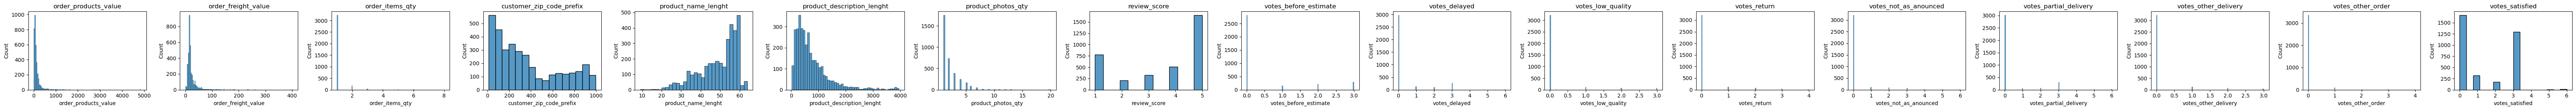

In [87]:
n = len(numeric_features)

# Настройка размера фигуры (важно для плотности)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 3))  # один ряд, n колонок

for i, col in enumerate(numeric_features):
    sns.histplot(data=df, x=col, ax=axes[i], kde=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Можно увидеть, что в признаках с непрерывным типом переменной есть выбросы. В дискретных признаках немного разных значений, поэтому это не будет проблемой в будущем.

Так как в будущем предполагается использование градиентного бустинга, то и требования к данным менее требовательные, поэтому:
1. Выбросы здесь не играют большой роли (однако преобразования распределений приветствуются);
2. Нужна правильная настройка при дисбалансе классов;
3. Крайне желательна предварительная обработка пропущенных значений.

Посмотрим на некоторые нелогичные значения признаков, например order_products_value = 0.

In [88]:
print(classified_data['order_products_value'].sort_values().head()) # проверка на заказы с нулевой стоимостью

2428    3.50
3516    4.52
2114    5.90
267     6.30
2699    6.90
Name: order_products_value, dtype: float64


In [89]:
print(classified_data['order_freight_value'].sort_values().head()) # проверка на размеры комиссии за доставку
print(classified_data['order_freight_value'].sort_values().tail())

956     0.00
2177    0.01
2622    0.02
1315    0.02
2799    0.08
Name: order_freight_value, dtype: float64
2753    185.48
120     233.59
661     236.64
1679    259.70
1247    401.58
Name: order_freight_value, dtype: float64


In [90]:
print(classified_data['order_items_qty'].sort_values().head()) # проверка на количество = 0 заказанных товаров
print(classified_data['order_items_qty'].sort_values().tail())

3552    1
3553    1
3554    1
3555    1
3556    1
Name: order_items_qty, dtype: int64
1247    6
2023    6
259     6
2594    6
661     8
Name: order_items_qty, dtype: int64


In [91]:
set(df.columns) - set(classified_data.columns)

{'product_category_name_english'}

In [92]:
set(classified_data.columns) - set(df.columns)

{'Unnamed: 0',
 'id',
 'order_sellers_qty',
 'product_category_name',
 'review_comment_title'}

## Создание временных признаков

На основе временных признаков можно создать новые полезные и хорошо интерпретируемые:
1. Время между оплатой заказа и подтверждением заказа на сайте (order_approved_at - order_purchase_timestamp): *payment_lag*
2. Время между подтверждением заказа и ориентировочным времени доставки (order_estimated_delivery_date - order_aproved_at): *estimated_shipping_lag*
3. Время между фактическим времени доставки и ожидаемым (order_delivered_customer_date - order_estimated_delivery_date): *actual_and_estimated_shipping_lag*
4. Время между рассылкой с просьбой оценить качество и ответом покупателя (review_answer_timestamp - review_creation_date): *customer_review_response_lag*
5. Время между подтверждением заказа и его прибытием (order_delivered_customer_date - order_aproved_at): *approval_and_arrival_lag*

In [93]:
diffs = FeatureUnion([
    ('payment_lag', DateDiffTransformer('order_purchase_timestamp',
                                        'order_aproved_at',
                                        'payment_lag_hours')),
    ('estimated_shipping_lag', DateDiffTransformer('order_aproved_at',
                                         'order_estimated_delivery_date',
                                         'estimated_shipping_lag_hours')),
    ('actual_and_estimated_shipping_lag', DateDiffTransformer('order_estimated_delivery_date',
                                         'order_delivered_customer_date',
                                         'actual_and_estimated_shipping_lag_hours')),
    ('customer_review_response_lag', DateDiffTransformer('review_creation_date',
                                         'review_answer_timestamp',
                                         'customer_review_response_lag_hours')),
    ('approval_and_arrival_lag', DateDiffTransformer('order_aproved_at',
                                         'order_delivered_customer_date',
                                         'approval_and_arrival_lag_hours')),
])

In [94]:
diff_matrix = diffs.fit_transform(df)

In [95]:
print(diff_matrix)

[[   0  516 -292   27  224]
 [   0  662 -579   77   83]
 [  39  448 -295  233  154]
 ...
 [  31  500 -322   45  178]
 [   0 1063 -453   21  611]
 [   0  256 -204  113   52]]


In [96]:
new_cols = [tr.new_col for _, tr in diffs.transformer_list]
classified_data_diffs  = pd.DataFrame(diff_matrix,
                         columns=new_cols,
                         index=df.index)

In [97]:
df = df.join(classified_data_diffs)

In [98]:
display(df.head())

,order_status,order_products_value,order_freight_value,order_items_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,...,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class,product_category_name_english,payment_lag_hours,estimated_shipping_lag_hours,actual_and_estimated_shipping_lag_hours,customer_review_response_lag_hours,approval_and_arrival_lag_hours
0,delivered,89.99,14.38,1,2017-08-30 11:41:01,2017-08-30 11:55:08.970352,2017-09-21,2017-09-08 20:35:27.276847,belo_horizonte,mg,...,0,3,satisfeito,satisfeito_com_pedido,health_beauty,0,516,-292,27,224
1,delivered,69.00,15.23,1,2017-09-26 09:13:36,2017-09-26 09:28:10.922048,2017-10-24,2017-09-29 21:13:04.984841,pocos_de_caldas,mg,...,0,0,antes_prazo,satisfeito_com_pedido,toys,0,662,-579,77,83
2,delivered,99.80,15.86,2,2018-01-15 15:50:42,2018-01-17 07:29:56.419769,2018-02-05,2018-01-23 17:51:31.134866,sao_jose_dos_campos,sp,...,0,0,entrega_parcial,problemas_de_entrega,garden_tools,39,448,-295,233,154
3,delivered,87.00,12.74,1,2018-02-04 11:16:42,2018-02-06 05:31:50.990164,2018-03-13,2018-02-20 19:38:06.633080,ribeirao_preto,sp,...,0,0,atrasado,problemas_de_entrega,computers_accessories,42,834,-485,26,350
4,delivered,99.90,17.95,1,2017-12-07 11:58:42,2017-12-08 02:36:49.587515,2018-01-03,2017-12-19 22:33:18.952512,rio_de_janeiro,rj,...,0,0,entrega_parcial,problemas_de_entrega,bed_bath_table,14,621,-338,76,283


In [99]:
classified_data_time = df[['most_voted_class', 'most_voted_subclass', 'payment_lag_hours', 'estimated_shipping_lag_hours', 'actual_and_estimated_shipping_lag_hours', 'customer_review_response_lag_hours', 'approval_and_arrival_lag_hours']]

## Анализ most_voted_class и most_voted_subclass

Пояснения к значениям most_voted_class и most_voted_subclass на английском:

##### **most_voted_class**:

*satisfeito_com_pedido* - satisfied with order

*problemas_de_entrega* - delivery issues

*problemas_de_qualidade* - quality issues

##### **most_voted_subclass**:

*satisfeito* - satisfied

*antes_prazo* - before estimated delivery time

*entrega_parcial* - partial delivery

*atrasado* - late delivery

*diferente_do_anunciado* - different from announced

*baixa_qualidade* - low quality

*devolucao* - refund

*outro_entrega* - wrong delivery

*outro_pedido* - wrong items delivered

Заменим португальский язык на английский:

In [100]:
df = df.replace({'satisfeito_com_pedido': 'satisfied_with_order',
                                           'problemas_de_entrega': 'delivery_issues',
                                           'problemas_de_qualidade': 'quality_issues',
                                           'satisfeito': 'satisfied',
                                           'antes_prazo': 'before_estimated_delivery_time',
                                           'entrega_parcial': 'partial_delivery',
                                           'atrasado': 'late_delivery',
                                           'diferente_do_anunciado': 'different_from_announced',
                                           'baixa_qualidade': 'low_quality',
                                           'devolucao': 'refund',
                                           'outro_entrega': 'wrong_delivery',
                                           'outro_pedido': 'wrong_items_delivered'})

In [101]:
print(df['most_voted_subclass'].value_counts())

most_voted_subclass
satisfied                         1486
before_estimated_delivery_time     490
partial_delivery                   397
late_delivery                      366
different_from_announced           163
low_quality                        146
refund                             127
wrong_delivery                     105
wrong_items_delivered               23
Name: count, dtype: Int64


Почти все из этих классов и подклассов объяснимы одним или несколькими признаками из таблицы, например подкласс late_delivery объясним временем доставки. Обозначим возможные взаимосвязи:
*satisfied_with_order* - потенциально любой признак связанный с доставкой и качеством товара;

*delivery_issues* - любой признак с информацией о доставке;

*quality_issues* - предстоит узнать;

*satisfied* - то же, что и *satisfied_with_order*;

*before_estimated_delivery_time* - признаки с информацией о приблизительном и фактическом времени доставки;

*partial_delivery* - признаки с информацией о количестве доставляемых товаров;

*late_delivery* - то же, что и *before_estimated_delivery_time*;

*different_from_announced* - предстоит узнать;

*low_quality* - предстоит узнать;

*refund* - возврат может происходить по разным причинам, сложно проанализировать;

*wrong_delivery* - предстоит узнать;

*wrong_items_delivered* - предстоит узнать.

Сделаем one-hot для most_voted_class и most_voted_subclass:

In [102]:
to_dummies = ['most_voted_class', 'most_voted_subclass']
classified_dummies = pd.get_dummies(df[to_dummies], prefix=to_dummies, dtype=int)
classified_rest = df.drop(columns=to_dummies)
df = pd.concat([classified_rest, classified_dummies], axis=1)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467 entries, 0 to 3466
Data columns (total 45 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   order_status                                        3467 non-null   object        
 1   order_products_value                                3467 non-null   float64       
 2   order_freight_value                                 3467 non-null   float64       
 3   order_items_qty                                     3467 non-null   int64         
 4   order_purchase_timestamp                            3467 non-null   datetime64[ns]
 5   order_aproved_at                                    3467 non-null   datetime64[ns]
 6   order_estimated_delivery_date                       3467 non-null   datetime64[ns]
 7   order_delivered_customer_date                       3467 non-null   datetime64[ns]
 8   customer

Исключим признаки, которые не несут информации для анализа классов и подклассов:

In [104]:
votes_features = ['votes_before_estimate', 'votes_delayed', 'votes_low_quality',
                  'votes_return', 'votes_not_as_anounced','votes_partial_delivery',
                  'votes_other_delivery', 'votes_other_order', 'votes_satisfied']

In [105]:
classified_data_classes_subclasses = df.drop('order_status', axis=1).drop(time_features, axis=1)#.drop(votes_features, axis=1)

Также исключим сложные в обработке категориальные признаки:

In [106]:
classified_data_classes_subclasses = classified_data_classes_subclasses.drop(['customer_city', 'customer_state', 'customer_zip_code_prefix', 'review_comment_message'], axis=1)

In [107]:
classified_data_classes_subclasses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467 entries, 0 to 3466
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   order_products_value                                3467 non-null   float64
 1   order_freight_value                                 3467 non-null   float64
 2   order_items_qty                                     3467 non-null   int64  
 3   product_name_lenght                                 3467 non-null   int64  
 4   product_description_lenght                          3467 non-null   int64  
 5   product_photos_qty                                  3467 non-null   int64  
 6   review_score                                        3467 non-null   int64  
 7   votes_before_estimate                               3467 non-null   int64  
 8   votes_delayed                                       3467 non-null   int64  
 9

Имеется проблема: неизвестно каким образом специалисты ставили метки классов для некоторых most_voted_class и most_voted_subclass. У нас имеется признак review_comment_message, который скорее всего несет данную информацию, однако без использования машинного обучения (например, BERT) невозможно эту информацию использовать. Поддержка оценки тональности комментариев может быть добавлена в будущих версиях, но на данном этапе от идеи придется отказаться. Возьмем лишь те метки, которые можно описать с помощью имеющихся данных:

In [108]:
classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'].describe()

count    3467.000000
mean     -244.468993
std       262.651366
min     -1698.000000
25%      -375.000000
50%      -286.000000
75%      -155.000000
max      3330.000000
Name: actual_and_estimated_shipping_lag_hours, dtype: float64

In [109]:
pd.set_option('display.max_columns', None)

In [110]:
display(classified_data_classes_subclasses[classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'] < classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'].median()].head())

,order_products_value,order_freight_value,order_items_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,votes_before_estimate,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,product_category_name_english,payment_lag_hours,estimated_shipping_lag_hours,actual_and_estimated_shipping_lag_hours,customer_review_response_lag_hours,approval_and_arrival_lag_hours,most_voted_class_delivery_issues,most_voted_class_quality_issues,most_voted_class_satisfied_with_order,most_voted_subclass_before_estimated_delivery_time,most_voted_subclass_different_from_announced,most_voted_subclass_late_delivery,most_voted_subclass_low_quality,most_voted_subclass_partial_delivery,most_voted_subclass_refund,most_voted_subclass_satisfied,most_voted_subclass_wrong_delivery,most_voted_subclass_wrong_items_delivered
0,89.99,14.38,1,59,492,3,5,0,0,0,0,0,0,0,0,3,health_beauty,0,516,-292,27,224,0,0,1,0,0,0,0,0,0,1,0,0
1,69.00,15.23,1,50,679,4,5,3,0,0,0,0,0,0,0,0,toys,0,662,-579,77,83,0,0,1,1,0,0,0,0,0,0,0,0
2,99.80,15.86,2,59,341,2,1,0,0,0,0,0,3,0,0,0,garden_tools,39,448,-295,233,154,1,0,0,0,0,0,0,1,0,0,0,0
3,87.00,12.74,1,45,411,1,4,0,3,0,0,0,0,0,0,0,computers_accessories,42,834,-485,26,350,1,0,0,0,0,1,0,0,0,0,0,0
4,99.90,17.95,1,60,189,1,3,0,0,0,0,0,3,0,0,0,bed_bath_table,14,621,-338,76,283,1,0,0,0,0,0,0,1,0,0,0,0


In [111]:
display(classified_data_classes_subclasses[classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'] < classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'].median()]['most_voted_subclass_before_estimated_delivery_time'].value_counts(normalize=True))

most_voted_subclass_before_estimated_delivery_time
0    0.832273
1    0.167727
Name: proportion, dtype: float64

Лишь 16% записей говорят о том, что доставка быстрее, чем на медианное значение разницы между ожидаемым и фактическим временем доставки (-286 часов, то есть быстрее в среднем на 12 дней) является меткой '1'. Кажется странным, что специалисты посчитали доставку на 12 дней раньше классом 'доставили раньше' лишь в 16% случаев. Посмотрим по 1-перцентилю:

In [112]:
display(classified_data_classes_subclasses[classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'] < classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'].quantile(0.01)].head())

,order_products_value,order_freight_value,order_items_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,votes_before_estimate,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,product_category_name_english,payment_lag_hours,estimated_shipping_lag_hours,actual_and_estimated_shipping_lag_hours,customer_review_response_lag_hours,approval_and_arrival_lag_hours,most_voted_class_delivery_issues,most_voted_class_quality_issues,most_voted_class_satisfied_with_order,most_voted_subclass_before_estimated_delivery_time,most_voted_subclass_different_from_announced,most_voted_subclass_late_delivery,most_voted_subclass_low_quality,most_voted_subclass_partial_delivery,most_voted_subclass_refund,most_voted_subclass_satisfied,most_voted_subclass_wrong_delivery,most_voted_subclass_wrong_items_delivered
177,189.99,20.82,1,42,2511,4,4,0,0,0,0,0,0,0,0,3,market_place,26,2221,-1698,72,524,0,0,1,0,0,0,0,0,0,1,0,0
369,473.70,52.08,3,44,936,1,1,0,0,0,0,0,3,0,0,0,perfumery,0,989,-842,36,148,1,0,0,0,0,0,0,1,0,0,0,0
939,67.70,37.61,1,27,570,3,5,1,0,0,0,0,0,0,0,2,housewares,0,1691,-1010,36,681,0,0,1,0,0,0,0,0,0,1,0,0
952,93.50,6.25,1,37,618,1,4,0,0,0,0,0,0,0,0,3,furniture_decor,0,1109,-802,181,307,0,0,1,0,0,0,0,0,0,1,0,0
1014,69.90,16.25,1,49,403,2,3,0,3,0,0,0,0,0,0,0,sports_leisure,0,895,-771,37,125,1,0,0,0,0,1,0,0,0,0,0,0


In [113]:
display(classified_data_classes_subclasses[classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'] < classified_data_classes_subclasses['actual_and_estimated_shipping_lag_hours'].quantile(0.01)]['most_voted_subclass_before_estimated_delivery_time'].value_counts(normalize=True))

most_voted_subclass_before_estimated_delivery_time
0    0.771429
1    0.228571
Name: proportion, dtype: float64

Мы имеем следующее: только 22% записей из нижнего 1% значений по actual_and_estimated_shipping_lag_hours отнесены специалистами к классу '1' в признаке most_voted_subclass_before_estimated_delivery_time, хотя очевидно, что если доставка произошла на 757 часов раньше (нижний 1%), то это точно класс '1'. Также в в описании к данным указано, что метки создавались экспертами на основе комментариев покупателей, хранящихся в признаке review_comment_message. Мной было предположено о связи содержания комментария с фактическими численными значениями (условно, если комментарий: "поздняя доставка", то примерный вывод: "метка '1' присуждается по признаку actual_and_estimated_shipping_lag_hours > 50"), но как можно увидеть, данная связь отсутствует как минимум для одного из потенциально важных признаков, которые мы можем проверить, и отсутствует возможность проверить для признаков типа most_voted_subclass_different_from_announced. Решено прекратить анализ для датасета classified_data за неинформативностью.